In [6]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from PIL import Image
import shapely.geometry
import pyproj
from dataclasses import dataclass

In [7]:
BASE_URL = 'https://maps.googleapis.com/maps/api/staticmap'

PROJ_DIR = './'
TESTS_DIR = PROJ_DIR + 'tests/'
RAW_TILES_PATH = 'raw_tiles/'
CROP_TILES_PATH = 'crop_tiles/'

ZOOM_LEVEL = 18

In [8]:
# Helpers
from math import log, pow
import os, os.path

def get_number_of_files_in_dir(dir=PROJ_DIR) -> int:
    return len([name for name in os.listdir(dir)])

def zoom_level_to_metres(zoom):
    return (40000 / pow(2, zoom)) * 2000

def metres_to_zoom_level(metres):
    return log(40000 / (metres / 2000), 2)

def get_google_api_key() -> str:
    with open(PROJ_DIR + 'google_api_key') as f:
        return f.readline()


In [9]:
class Tile:
    SUCCESS = "SUCCESS"

    def __init__(self, lat: float, lon: float, scale: int=1, zoom: int=ZOOM_LEVEL, size: int=200, type: str='satellite', overwrite: bool=False):
        self.copyright_height = 50
        self.lat = lat
        self.lon = lon
        self.zoom = zoom
        self.scale = scale
        self.width = size
        self.height = size + self.copyright_height*2
        self.map_type = type
        self.url = self._get_tile_url()
        self.overwrite = overwrite
    

    def _get_tile_url(self) -> str:
        url = BASE_URL + '?key=' + get_google_api_key()
        url += '&maptype=' + self.map_type
        url += '&center=' + str(self.lat) + ',' + str(self.lon)
        url += '&zoom=' + str(self.zoom)
        url += '&scale=' + str(self.scale)
        url += '&size=' + str(self.width) + 'x' + str(self.height)
        return url
    

    def _fetch(self, url) -> bytes:
        r = requests.get(url)
        response = r.content
        return [response, None] if r.status_code == 200 else [None, str(response)]


    def _save_tile(self, img_data: bytes, dir: str, file_name: str) -> str:
        path = dir + file_name
        with open(path, 'wb') as handler:
            handler.write(img_data)
        return path


    def _remove_google_logo(self, path):
        img = Image.open(path)
        width, height = img.size
        left = 0
        top = self.copyright_height*self.scale
        right = width
        bottom = height - self.copyright_height*self.scale
        cropped = img.crop((left, top, right, bottom))
        byte_arr = io.BytesIO()
        cropped.save(byte_arr, format='PNG')
        return byte_arr.getvalue()


    def _show_tile(self, img_path):
        img_data = mpimg.imread(img_path)
        plt.figure(figsize = (10,10))
        plt.imshow(img_data)
        plt.axis('off')


    def _file_exists(self, file_name, dir):
        if self.overwrite: 
            return False
        raw_path = dir + RAW_TILES_PATH + file_name
        crop_path = dir + CROP_TILES_PATH + file_name
        return os.path.exists(raw_path) and os.path.exists(crop_path)


    def run(self, test_name="test", show_image=True) -> str:
        file_name = str(self.lat) + "_" + str(self.lon) + "_" + "zl" + str(self.zoom) + '.png'
        dir = TESTS_DIR + test_name + "/"
        if not self._file_exists(file_name, dir):
            print("Fetching new tile... ")
            [raw_img_data, img_fetch_error] = self._fetch(self.url)
            if raw_img_data:
                raw_img_path = self._save_tile(raw_img_data, dir + RAW_TILES_PATH, file_name)
                cropped_data = self._remove_google_logo(raw_img_path)
                cropped_img_path = self._save_tile(cropped_data, dir + CROP_TILES_PATH, file_name)
                if show_image:
                    self._show_tile(cropped_img_path)
                return Tile.SUCCESS
            else:
                return "Failed to fetch image from Google Maps: " + img_fetch_error
        else:
            return "File " + file_name + " already exists, skipping..."


In [17]:
@dataclass
class MapGridArea:
    sw_lat: float
    sw_lon: float
    ne_lat: float
    ne_lon: float


class MapGridTiles:
    """
    Using: https://stackoverflow.com/a/40343603
    """
    
    def __init__(self, stepsize):
        # Step size in metres
        self.stepsize = stepsize 
        # Set up transformers, EPSG:3857 is metric, same as EPSG:900913
        self.to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857')
        self.to_original_transformer = pyproj.Transformer.from_crs('epsg:3857', 'epsg:4326')


    def add_m_to_coordinate(self, lat, lon, x, y):
        coordinate = shapely.geometry.Point((lat, lon))
        transformed = self.to_proxy_transformer.transform(coordinate.x, coordinate.y)
        x = transformed[0] + x
        y = transformed[1] + y
        return shapely.geometry.Point(self.to_original_transformer.transform(x, y))

    def create_grid(self, area: MapGridArea) -> list[shapely.geometry.Point]:
        # Create corners of rectangle to be transformed to a grid
        sw = shapely.geometry.Point((area.sw_lat, area.sw_lon))
        ne = shapely.geometry.Point((area.ne_lat, area.ne_lon))

        # Project corners to target projection
        transformed_sw = self.to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
        transformed_ne = self.to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

        # Iterate over 2D area
        gridpoints = []
        x = transformed_sw[0]
        while x < transformed_ne[0]:
            y = transformed_sw[1]
            while y < transformed_ne[1]:
                p = shapely.geometry.Point(self.to_original_transformer.transform(x, y))
                gridpoints.append(p)
                y += self.stepsize
            x += self.stepsize

        return gridpoints


    def save_to_csv(self, gridpoints, test_name: str, file_name: str='gridpoints'):
        path = TESTS_DIR + test_name + '/' + file_name + '.csv'
        d = self.stepsize / 2
        with open(path, 'w') as of:
            of.write('lat,long,tl_lat,tl_lon,tr_lat,tr_lon,bl_lat,bl_lon,br_lat,br_lon,size\n')
            for p in gridpoints:
                tl = self.add_m_to_coordinate(p.x, p.y, -d, -d)
                tr = self.add_m_to_coordinate(p.x, p.y, +d, -d)
                bl = self.add_m_to_coordinate(p.x, p.y, -d, +d)
                br = self.add_m_to_coordinate(p.x, p.y, +d, +d)
                of.write('{:f},{:f},{:f},{:f},{:f},{:f},{:f},{:f},{:f},{:f},{:f}\n'.format(
                    p.x, p.y,
                    tl.x, tl.y,
                    tr.x, tr.y,
                    bl.x, bl.y,
                    br.x, br.y,
                    self.stepsize
                ))
    

    def save_to_mobisoftinfotech(self, gridpoints, test_name: str, file_name: str='gridpoints'):
        path = TESTS_DIR + test_name + '/' + 'mobisoftinfotech_' + file_name + '.csv'
        with open(path, 'w') as of:
            # of.write('lon;lat\n')
            for p in gridpoints:
                of.write('{:f},{:f},black,circle,"P"\n'.format(p.x, p.y))


# Code

This will generate a Google Maps tile and save the original, and the cropped without Google logo, to the test_name folder

Zoom = 20
Zoom in metres = 76.2939453125
Fetching new tile... 


'SUCCESS'

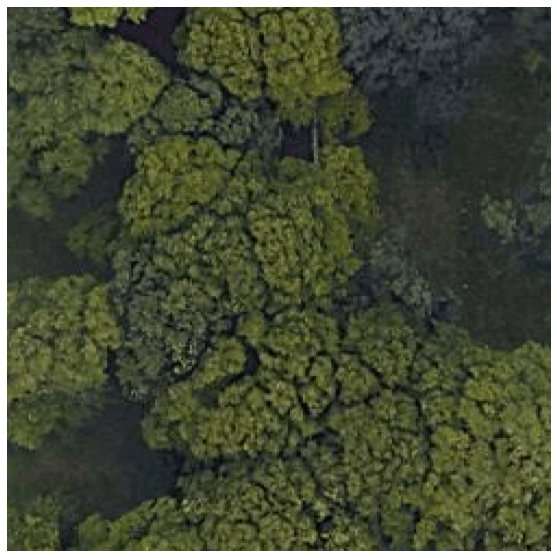

In [195]:
zoom = 20
print("Zoom = " + str(zoom))
print("Zoom in metres = " + str(zoom_level_to_metres(zoom)))

tile = Tile(lat=55.942191, lon=-3.191464, zoom=zoom, scale=2)
tile.run()

This will generate best-fit grid points for longitude and latitude with a bounding area and a step size

In [18]:
ALL_EDINBURGH_MAP_AREA = MapGridArea(55.881181, -3.330831, 55.994076, -3.039482)
CENTRAL_EDINBURGH_MAP_AREA = MapGridArea(55.944769, -3.210770, 55.958695, -3.180100)
MEADOWS_MAP_AREA = MapGridArea(55.939567, -3.200461, 55.944766, -3.187255)

STEP_SIZE = zoom_level_to_metres(20)

tiles = MapGridTiles(stepsize=STEP_SIZE)

gridpoints = tiles.create_grid(MEADOWS_MAP_AREA)
print(len(gridpoints))
tiles.save_to_csv(gridpoints, "meadows", "meadows_data")

280


This combines the grid plotting with the Google maps tile to generate tiles for a given area

Use this site: https://mobisoftinfotech.com/tools/plot-multiple-points-on-map/

... to show plot points on a map. Copy from `./tests/{TEST_NAME}/gridpoints_zlXX.csv` and paste into the site.

In [1]:
def run_test(test_name, area, zoom_level):
    tiles = MapGridTiles(stepsize=zoom_level_to_metres(20))
    gridpoints = tiles.create_grid(area)
    tiles.save_to_mobisoftinfotech(gridpoints, test_name, 'gridpoints_zl' + str(zoom_level))

    i = 0
    for gridpoint in gridpoints:
        print(">>> TILE", i, gridpoint.x, gridpoint.y)
        tile = Tile(lat=gridpoint.x, lon=gridpoint.y, zoom=20, scale=2)
        status = tile.run(test_name, show_image=False)
        print(status)
        i += 1


run_test("meadows", MEADOWS_MAP_AREA, 20)

NameError: name 'MEADOWS_MAP_AREA' is not defined